# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import re
from datetime import datetime, timedelta
import math


# Any results you write to the current directory are saved as output.

/kaggle/input/world-cities/worldcities.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/income-by-country/Income by Country.xlsx


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Проверка на уникальность
Проверим полностью дублирующиеся строки



In [6]:
data.duplicated(subset=None, keep='first').value_counts()

False    50000
dtype: int64

Полностью дублирующихся строк нет.

Проверим отдельные поля датасета на наличие повторений и дубликатов

### 'Restaurant_id'


In [7]:
len(data['Restaurant_id'].value_counts().loc[lambda x : x > 1].index)

9287

Как видно есть повторяющиеся значения. Выясним, что они означают.

In [8]:
data['Restaurant_id'].value_counts().loc[lambda x : x > 1].index[:10]

Index(['id_227', 'id_633', 'id_436', 'id_871', 'id_585', 'id_430', 'id_321',
       'id_344', 'id_71', 'id_534'],
      dtype='object')

Строки с одинаковым 'Restaurant_id' имеют различные, не повторяющиеся поля как городов, типов кухонь, так и идентификаторов ID_TA. Можно предположить, что это не ошибка данных,  скорее всего поле означает  не конкретный ресторан, а сеть  ресторанов или одного владельца.


### 'City'

In [9]:
data['City'].value_counts().sort_index(ascending=True)

Amsterdam     1372
Athens         776
Barcelona     3395
Berlin        2705
Bratislava     380
Brussels      1314
Budapest      1021
Copenhagen     819
Dublin         836
Edinburgh      745
Geneva         590
Hamburg       1186
Helsinki       475
Krakow         554
Lisbon        1647
Ljubljana      222
London        7193
Luxembourg     263
Lyon          1126
Madrid        3813
Milan         2694
Munich        1145
Oporto         642
Oslo           488
Paris         6108
Prague        1816
Rome          2589
Stockholm     1033
Vienna        1443
Warsaw         925
Zurich         685
Name: City, dtype: int64

In [10]:
cities_list = list(data['City'].value_counts().index)

C названиями городов все в порядке

## 'Cuisine Style'

У данного признака присутствую пропуске в наборе данных.

Посмотрим более детально какие кухни преобладают в общей выборке и отдельно по городам.

In [11]:
data['Cuisine Style'].value_counts(dropna=False).head(20)

NaN                             11590
['Italian']                      1332
['French']                       1019
['Spanish']                       860
['French', 'European']            503
['Cafe']                          500
['Pizza']                         454
['Italian', 'Pizza']              422
['Chinese']                       418
['European', 'Portuguese']        415
['Mediterranean']                 311
['Bar', 'Pub']                    307
['Mediterranean', 'Spanish']      293
['Vegetarian Friendly']           276
['Indian']                        270
['Fast Food']                     263
['International']                 247
['Japanese']                      247
['Italian', 'Mediterranean']      245
['European']                      245
Name: Cuisine Style, dtype: int64

In [12]:
data[['City', 'Cuisine Style']].groupby('City').describe()

Cuisine Style                                                     
                   count unique                                      top freq
City                                                                         
Amsterdam           1170    717                    ['Dutch', 'European']   33
Athens               627    302                                ['Greek']   92
Barcelona           2608   1021                              ['Spanish']  249
Berlin              1793    784                              ['Italian']   96
Bratislava           236    162                                  ['Pub']   15
Brussels             992    491                  ['Belgian', 'European']   54
Budapest             819    509                ['European', 'Hungarian']   72
Copenhagen           616    360                   ['European', 'Danish']   21
Dublin               704    440                  ['Irish', 'Bar', 'Pub']   24
Edinburgh            649    412                                 ['Cafe']   17
Geneva               474    261  ['French', 'Mediterranean', 'European']   23
Hamburg              666    349                              ['Italian']   29
Helsinki             373    235                           ['Bar', 'Pub']   11
Krakow               436    282                   ['Polish', 'European']   42
Lisbon              1248    513               ['European', 'Portuguese']  269
Ljubljana            189    146                ['European', 'Slovenian']   10
London              5983   2220                ['Bar', 'British', 'Pub']  209
Luxembourg           222    143                               ['French']   11
Lyon                 747    255                               ['French']  192
Madrid              2634    857                              ['Spanish']  514
Milan               1986    700                              ['Italian']  335
Munich               816    429                              ['Italian']   34
Oporto               492    246               ['European', 'Portuguese']  100
Oslo                 388    292                                  ['Pub']   10
Paris               4800   1153                               ['French']  674
Prague              1509    651                    ['European', 'Czech']  228
Rome                2270    854                              ['Italian']  230
Stockholm            723    390                  ['European', 'Swedish']   35
Vienna              1041    573                 ['Austrian', 'European']   90
Warsaw               671    381                   ['Polish', 'European']   52
Zurich               528    362                    ['Swiss', 'European']   19

In [13]:
data[['City', 'Cuisine Style']].groupby('City')['Cuisine Style'].value_counts()['London'].head(10)

Cuisine Style
['Bar', 'British', 'Pub']                           209
['British']                                         148
['Cafe']                                            122
['Indian']                                           99
['Italian']                                          93
['Bar', 'British', 'Pub', 'Vegetarian Friendly']     87
['Chinese']                                          75
['Chinese', 'Asian']                                 68
['Bar', 'Pub']                                       59
['Fast Food']                                        55
Name: Cuisine Style, dtype: int64

In [14]:
data[['City', 'Cuisine Style']].groupby('City')['Cuisine Style'].value_counts()['London'].head(1).index[0]

"['Bar', 'British', 'Pub']"

Посчитаем количество встречающихся стилей кухонь в предлагаемых наборах стилей.

In [15]:
cuisine_dict = {}
styles_count = []
for style_set in data[data['Cuisine Style'].notna()]['Cuisine Style']:
    style_set_list = style_set.replace('"', '').replace('[', '').replace(']', '').replace("'", "").\
                    replace(', ', ',').split(',') 
    styles_count.append(len(style_set_list))
    for cuisine_style in style_set_list:
        if cuisine_style in cuisine_dict:
            cuisine_dict[cuisine_style] += 1
        else:
            cuisine_dict[cuisine_style] = 1

sorted_cuisine_dict = {}
sorted_keys = sorted(cuisine_dict, key=cuisine_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_cuisine_dict[w] = cuisine_dict[w]

sorted_cuisine_dict

{'Salvadoran': 1,
 'Xinjiang': 1,
 'Burmese': 1,
 'Latvian': 1,
 'Yunnan': 2,
 'Polynesian': 2,
 'Fujian': 2,
 'Welsh': 3,
 'Azerbaijani': 3,
 'Caucasian': 4,
 'Native American': 5,
 'Uzbek': 5,
 'Canadian': 7,
 'New Zealand': 7,
 'Ecuadorean': 8,
 'Albanian': 8,
 'Minority Chinese': 12,
 'Central Asian': 12,
 'Romanian': 13,
 'Chilean': 16,
 'Armenian': 17,
 'Filipino': 17,
 'Georgian': 18,
 'Mongolian': 20,
 'Ukrainian': 20,
 'Singaporean': 21,
 'Cambodian': 22,
 'Tunisian': 23,
 'Hawaiian': 23,
 'Southwestern': 24,
 'Egyptian': 24,
 'Afghani': 27,
 'Cajun & Creole': 27,
 'Tibetan': 29,
 'Colombian': 30,
 'Sri Lankan': 30,
 'Taiwanese': 30,
 'Cuban': 32,
 'Croatian': 33,
 'Australian': 36,
 'Jamaican': 36,
 'Malaysian': 38,
 'Ethiopian': 51,
 'Venezuelan': 51,
 'Kosher': 56,
 'Arabic': 58,
 'Russian': 66,
 'Indonesian': 71,
 'Persian': 77,
 'Slovenian': 85,
 'Israeli': 90,
 'Norwegian': 96,
 'Bangladeshi': 100,
 'Balti': 104,
 'Nepali': 121,
 'Caribbean': 124,
 'Peruvian': 130,
 'Pak

## 'Price Range'

In [16]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [17]:
data[['City', 'Price Range']].groupby('City').describe()

Price Range                       
                 count unique       top  freq
City                                         
Amsterdam         1052      3  $$ - $$$   794
Athens             532      3  $$ - $$$   328
Barcelona         2257      3  $$ - $$$  1561
Berlin            1448      3  $$ - $$$   964
Bratislava         176      3  $$ - $$$   124
Brussels           858      3  $$ - $$$   639
Budapest           699      3  $$ - $$$   446
Copenhagen         542      3  $$ - $$$   414
Dublin             634      3  $$ - $$$   466
Edinburgh          600      3  $$ - $$$   388
Geneva             402      3  $$ - $$$   318
Hamburg            525      3  $$ - $$$   388
Helsinki           317      3  $$ - $$$   237
Krakow             377      3  $$ - $$$   220
Lisbon            1085      3  $$ - $$$   704
Ljubljana          158      3  $$ - $$$   104
London            5196      3  $$ - $$$  3651
Luxembourg         189      3  $$ - $$$   163
Lyon               597      3  $$ - $$$   469
Madrid            2122      3  $$ - $$$  1560
Milan             1620      3  $$ - $$$   990
Munich             726      3  $$ - $$$   554
Oporto             441      3  $$ - $$$   259
Oslo               334      3  $$ - $$$   250
Paris             4121      3  $$ - $$$  3109
Prague            1117      3  $$ - $$$   743
Rome              2060      3  $$ - $$$  1317
Stockholm          554      3  $$ - $$$   458
Vienna             866      3  $$ - $$$   665
Warsaw             562      3  $$ - $$$   393
Zurich             472      3  $$ - $$$   365

Как видно ценовой диапазон, что в общей выборке, что по городам в основном средний '\$\$ \- \$\\$\\$'.

## 'Number of Revews'

In [18]:
data['Number of Reviews'].value_counts(dropna=False)

NaN       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

In [19]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [20]:
data[['City', 'Number of Reviews']].groupby('City').describe()

Number of Reviews                                            \
                       count        mean         std  min   25%    50%   
City                                                                     
Amsterdam             1303.0  148.744436  330.452299  2.0  12.0   46.0   
Athens                 721.0   93.987517  282.863372  2.0   7.0   22.0   
Barcelona             3165.0  135.683096  308.794769  2.0   9.0   35.0   
Berlin                2445.0   63.772188  165.759296  2.0   6.0   17.0   
Bratislava             323.0   51.616099  171.215552  2.0   4.0   10.0   
Brussels              1230.0   92.647154  256.491108  2.0   8.0   28.0   
Budapest               935.0  158.680214  453.755563  2.0   8.0   24.0   
Copenhagen             775.0   95.058065  189.314438  2.0   9.0   33.0   
Dublin                 796.0  154.276382  314.491662  2.0  12.0   44.0   
Edinburgh              724.0  237.711326  441.284317  2.0  14.0   69.5   
Geneva                 548.0   62.173358  117.204742  2.0   9.0   30.5   
Hamburg               1078.0   45.318182   89.372650  2.0   6.0   16.0   
Helsinki               447.0   66.020134  139.741745  2.0   8.0   21.0   
Krakow                 518.0  130.569498  312.625956  2.0   8.0   28.0   
Lisbon                1536.0  127.830078  284.973697  2.0   8.0   31.0   
Ljubljana              207.0   88.256039  205.356515  2.0   8.0   20.0   
London                6768.0  137.968381  330.194687  2.0   9.0   38.0   
Luxembourg             250.0   83.268000  118.318593  2.0  11.0   35.0   
Lyon                  1079.0   87.073216  152.844238  2.0  10.0   31.0   
Madrid                3575.0   99.911888  252.875992  2.0   8.0   27.0   
Milan                 2563.0  168.298869  322.838298  2.0  12.0   47.0   
Munich                1061.0   77.649387  204.742221  2.0  10.0   29.0   
Oporto                 599.0  134.148581  298.579910  2.0   9.0   36.0   
Oslo                   466.0  100.004292  184.443820  2.0  10.0   29.0   
Paris                 5817.0  117.040915  231.714919  2.0  12.0   44.0   
Prague                1607.0  124.377722  341.818645  2.0   6.0   19.0   
Rome                  2513.0  289.787107  490.114193  2.0  35.0  119.0   
Stockholm              952.0   75.197479  166.225794  2.0   7.0   20.5   
Vienna                1325.0   80.535094  232.756044  2.0   7.0   21.0   
Warsaw                 829.0   67.112183  178.118422  2.0   6.0   17.0   
Zurich                 645.0   72.510078  127.370841  2.0  10.0   30.0   

                            
               75%     max  
City                        
Amsterdam   148.00  6777.0  
Athens       67.00  4234.0  
Barcelona   128.00  4996.0  
Berlin       51.00  2572.0  
Bratislava   30.00  2578.0  
Brussels     90.75  6437.0  
Budapest    113.00  7575.0  
Copenhagen  105.50  3426.0  
Dublin      157.00  3491.0  
Edinburgh   269.75  4567.0  
Geneva       74.00  1624.0  
Hamburg      42.00   845.0  
Helsinki     61.50  1488.0  
Krakow      123.00  4608.0  
Lisbon      111.00  3404.0  
Ljubljana    60.50  2006.0  
London      132.00  9660.0  
Luxembourg   98.00   652.0  
Lyon         93.50  1953.0  
Madrid       89.00  6013.0  
Milan       206.00  6360.0  
Munich       75.00  4694.0  
Oporto      127.00  3206.0  
Oslo         99.00  1391.0  
Paris       129.00  7622.0  
Prague       82.50  4521.0  
Rome        351.00  8927.0  
Stockholm    65.00  1461.0  
Vienna       68.00  4937.0  
Warsaw       49.00  2356.0  
Zurich       82.00  1974.0

## 'Reviews'

In [21]:
len(data['Reviews'].value_counts().loc[lambda x : x > 1])

31

In [22]:
data['Reviews'].value_counts().loc[lambda x : x > 1]

[[], []]                                                                                                                              8112
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                                        2
[['Delicious'], ['06/06/2017']]                                                                                                          2
[['Fantastic food, Excellent service', 'Surprising good Indian food in Spain'], ['01/07/2018', '11/08/2017']]                            2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                                         2
[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]                                                                            2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                                                  2
[['Good Lebanese food', 'De

В датасете встречаются дублированные отзывы. Количество повторов не более двух. Также 8112 записей с пустыми отзывами

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [23]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [24]:
# Создадим класс для обработки пропусков объектами которого можно формировать 
# различные способы заполнения пропусков

class FillNaByFeature():
    def __init__(self, feature, value, data):
        self.df = data[[feature, value]].groupby(feature).describe()
        self.feature = feature
        self.value = value
    
    def fill_na(self, row, statistic=0):
        #if np.isnan(row[self.value]):
        if pd.isnull(row[self.value]):
            if statistic == 'mean':
                return self.df[self.value, 'mean'][row[self.feature]]
            if statistic == 'median':
                return self.df[self.value, '50%'][row[self.feature]]
            if statistic == 'top':
                return self.df[self.value, 'top'][row[self.feature]]
            if statistic == 0:
                return 0
        else:
            return row[self.value]

In [25]:
# Создаем объект для заполнения пропусков признака 'Number of Reviews' по городу
filling_number_of_review = FillNaByFeature('City', 'Number of Reviews', data )

In [26]:
# Создадим объект для заполнения пропусков признака 'Price Range' по городу
filling_price_range = FillNaByFeature('City', 'Price Range', data)

In [27]:
# Заполним пропуски 'Number of Reviews' медианой по городу
data['Number of Reviews'] = data.apply(filling_number_of_review.fill_na, args=('median',), axis=1)

In [28]:
# Заполним пропуски 'Price Range' часто встречающимся значением по городу
data['Price Range'] = data.apply(filling_price_range.fill_na, args=('top',), axis=1)

In [29]:
# Создадим объект для заполнения пропусков признака 'Cuisine Style' по городу
filling_cuisine_style = FillNaByFeature('City', 'Cuisine Style', data)

In [30]:
# Заполним пропуски 'Cuisine Style' часто встречающимся значением по городу
data['Cuisine Style'] = data.apply(filling_cuisine_style.fill_na, args=('top',), axis=1)

In [31]:
# Заполнил вначале пропуски в поле 'Reviews' пустым значением как и у других записей с пустыми обзорами. Добавим отдельное поле 'Reviews_isNaN' для пустых обзоров.
# Затем распарсим значения на отдельные отзывы и их даты.
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [32]:
data['Reviews_isNaN'] = data['Reviews'].apply(lambda x: 1 if x == '[[], []]' else 0)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null object
Number of Reviews          50000 non-null float64
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_Style_isNAN        50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
Reviews_isNaN              50000 non-null int64
dtypes: float64(3), int64(2), object(7), uint8(3)
memory usage: 4.7+ MB


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [34]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10731
Ranking                    12975
Price Range                    3
Number of Reviews           1576
Reviews                    41857
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Cuisine_Style_isNAN            2
Price_Range_isNAN              2
Reviews_isNaN                  2
dtype: int64

In [35]:
# Обработка 'Price Range'

data['Price Range'] = data['Price Range'].apply(lambda x: 3 if x == '$$$$' else x)
data['Price Range'] = data['Price Range'].apply(lambda x: 2 if x == '$$ - $$$' else x)
data['Price Range'] = data['Price Range'].apply(lambda x: 1 if x == '$' else x)

In [36]:
# Обработка признака 'Cuisine Style'

data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace('"', '').replace('[', '').replace(']', '').replace("'", "").replace(', ', ',').split(','))
df_cuisine_style = data['Cuisine Style'].str.join('@').str.get_dummies('@')
data = pd.concat([data, df_cuisine_style], axis=1)

In [37]:
# Добавим дополнительный признак - количество стилей кухонь в ресторане

data['cuisine_style_count'] = data['Cuisine Style'].apply(lambda x: len(x))

In [38]:
# Функция для парсинга поля 'Reviews' 
# Входные данные: строка, индекс (0 - 3)
# Выходные данные: Строки обзора, либо даты

def review_parsing(input_str, index=""):
    input_str = input_str.replace("[", "").replace("]", "")
    begin_item = True
    limiter = ""
    out_list = []
    out_str =""
    limiter_count = 0
    for symbol in enumerate(input_str):
        if begin_item and symbol[1] != ' ' and symbol[1] != ',' and limiter_count == 0:
            limiter = symbol[1]
            begin_item = False
            limiter_count += 1
        elif symbol[1] == limiter:
            if symbol[0] < len(input_str) - 1 and symbol[0] > 0:
                if input_str[symbol[0] + 1] == ',' and (input_str[symbol[0] - 1] != '\\' or \
                                                        input_str[symbol[0] - 1] == '\\' and input_str[symbol[0] - 2] == '\\'):
                    limiter_count += 1
            else:
                limiter_count += 1
            if limiter_count == 2:
                out_list.append(out_str)
                out_str = ""
                begin_item = True
                limiter_count = 0
        elif limiter_count == 1:
            out_str += symbol[1]
    if len(out_list) == 0:
        out_list =  [np.NaN, np.NaN, np.NaN, np.NaN]
    elif len(out_list) == 2:
        out_list.insert(1, np.NaN)
        out_list.append(np.NaN)
    if index == '':
        return out_list
    else:
        return out_list[index]

In [39]:
# Из данных 'Reviews' извлечем последний отзыв
data['last_review'] = data['Reviews'].apply(review_parsing, index=0)

In [40]:
# Из данных 'Reviews' извлечем дату последнего отзыва
data['last_review_date'] =  pd.to_datetime(data['Reviews'].apply(review_parsing, index=2))

In [41]:
# Из данных 'Reviews' извлечем предпоследний отзыв
data['prev_review'] = data['Reviews'].apply(review_parsing, index=1)

In [42]:
# Из данных 'Reviews' извлечем дату предпоследнего отзыва
data['prev_review_date'] = pd.to_datetime(data['Reviews'].apply(review_parsing, index=3))

In [43]:
# Создадим новый признак - количество дней прошедших между последним и предпоследним отзывом
data['review_days_elasped'] = (data.last_review_date - data.prev_review_date).apply(lambda x: abs(x.days))

In [44]:
data[['Reviews', 'last_review', 'last_review_date', 'prev_review', 'prev_review_date', 'review_days_elasped' ]]

,Reviews,last_review,last_review_date,prev_review,prev_review_date,review_days_elasped
0,"[[], []]",NaN,NaT,NaN,NaT,NaN
1,"[['Very good reviews!', 'Fine dining in Hakani...",Very good reviews!,2017-12-05,Fine dining in Hakaniemi,2017-10-29,37.0
2,"[['Better than the Links', 'Ivy Black'], ['12/...",Better than the Links,2017-12-28,Ivy Black,2017-12-06,22.0
3,"[['Most exquisite', 'Delicious and authentic']...",Most exquisite,2017-12-06,Delicious and authentic,2017-11-22,14.0
4,"[['Always the best in bratislava', 'Very good ...",Always the best in bratislava,2018-02-08,Very good but pricey,2018-01-24,15.0
...,...,...,...,...,...,...
49995,"[['The real Italian experience!', 'Wonderful f...",The real Italian experience!,2017-12-16,"Wonderful food, wonderful experience",2017-11-12,34.0
49996,"[['Parisian atmosphere', 'Bit pricey but inter...",Parisian atmosphere,2017-12-21,Bit pricey but interesting decor and good...,2017-12-12,9.0
49997,"[['Good by swedish standards', 'A hidden jewel...",Good by swedish standards,2016-11-03,A hidden jewel in the middle of Västertorp...,2008-04-12,3127.0
49998,"[['Underground restaurant', 'Oldest Restaurant...",Underground restaurant,2017-07-11,Oldest Restaurant in Warsaw,2017-06-18,23.0


In [45]:
# Создадим новые признаки, кол-во символов в отзыве, пропущенные отзывы заполним нулями
data['last_review_len'] = data['last_review'].apply(lambda x: len(x) if pd.notnull(x) else 0)
data['prev_review_len'] = data['prev_review'].apply(lambda x: len(x) if pd.notnull(x) else 0)

In [46]:
data['review_days_elasped'] = data['review_days_elasped'].fillna(9999)

In [47]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 148 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_Style_isNAN        50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
Reviews_isNaN              50000 non-null int64
Afghani                    50000 non-null int64
African                    50000 non-null int64
Albanian                   50000 non-null int64
American      

In [48]:
#новые полиномиальные признаки
data['number_reviews_ranking'] = data['Number of Reviews'] * data['Ranking']
data['numberofr_rank'] = data['Number of Reviews'] / data['Ranking']

In [49]:
#функции определения положительных и отрицательных слов в отзывах
def find_good_words(s):
    """
    Выявление количества положительных слов в отзывах
    """
    good_words = ['good', 'yummy', 'fine', 'great', 'tasty',
                  'satisfaction', 'amazing', 'nice', 'best',
                  'friendly', 'pleasant', 'exellent', 'loved',
                  'love', 'lovely', 'welcoming', 'wonderful',
                  'perfect', 'delicious', 'favourite', 'sweet',
                  'yum', 'adequate', 'happy', 'beautiful', 'liked', 
                  'like', 'finest', 'greatest', 'excellent', 'paramount', 
                  'preeminent', 'superlative', 'top', 'unsurpassed', 
                  'amazing', 'astonishing', 'awe-inspiring', 'awesome', 
                  'awful', 'awing']
    count = 0
    for item in good_words:
        if item in s:
            count += 1
    return(count)

def find_bad_words(s):
    """
    Выявление количества отрицательных слов в отзывах
    """
    bad_words = ['bad', "poor", "ill", "low", "inferior", "wretched",
                 'badly', 'awry', "unpalatable", "unappetizing", "unsavory",
                 "istasteful", "unpleasant", "nasty", "dirty", "rough", "roughly", "tough",
                 "ugly", "graceless", "rudeness", 'boorishness', 'loutishness', 
                 'disagreeable', 'nasty', 'soiled', 'sordid', 'unclean', 'unwashed',
                 'indecent', 'lewd', 'obscene', 'raunchy', 'salacious',
                 'cheating', 'foul', 'unsporting', 'unsportsmanlike']
    count = 0
    for item in bad_words:
        if item in s:
            count += 1
    return(count)

data['Good_rev'] = data.Reviews.str.lower().apply(find_good_words)
data['Bad_rev'] = data.Reviews.str.lower().apply(find_bad_words)
data['Rev_delta'] = data['Good_rev'] - data['Bad_rev']

In [50]:
# убираем не нужные для модели признаки
data.drop(['Restaurant_id', 'Cuisine Style', 'Reviews', 'ID_TA','URL_TA', \
                 'last_review', 'last_review_date', 'prev_review', 'prev_review_date'], axis = 1, inplace=True)

In [51]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 144 columns):
City                       50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_Style_isNAN        50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
Reviews_isNaN              50000 non-null int64
Afghani                    50000 non-null int64
African                    50000 non-null int64
Albanian                   50000 non-null int64
American                   50000 non-null int64
Arabic                     50000 non-null int64
Argentinean                50000 non-null int64
Armenian                   50000 non-null int64
Asian                      50000 non-null int64
Australian         

In [52]:
# Создание dummi-переменных по колонке 'City'
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

### Графики и диаграммы

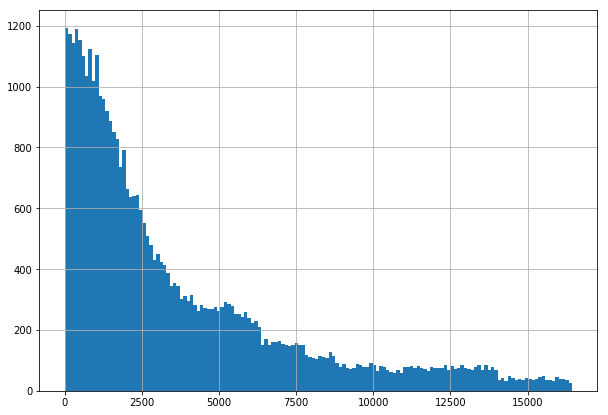

In [54]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=150)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

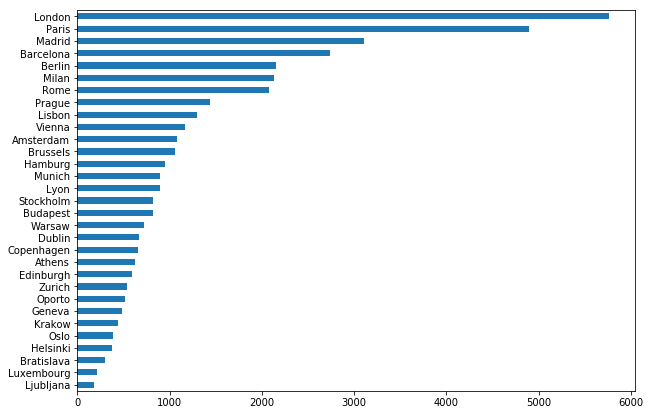

In [55]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

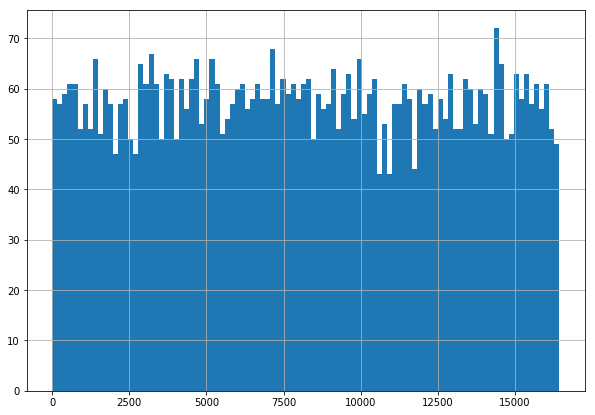

In [56]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

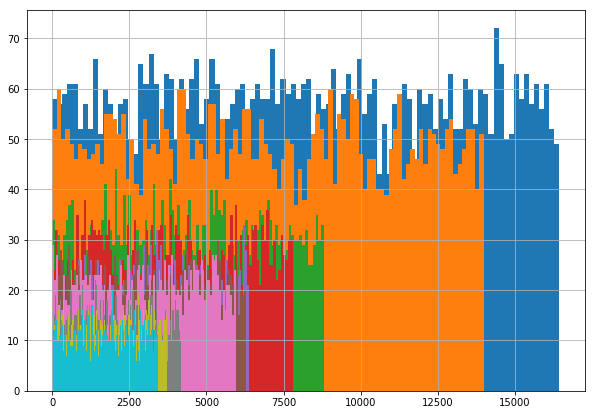

In [57]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Распределение целевой переменной

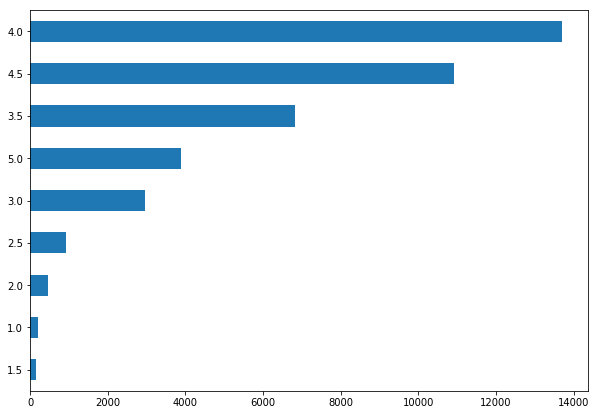

In [58]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

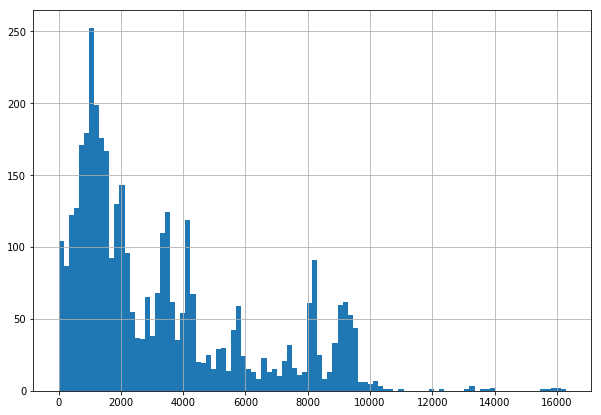

In [59]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

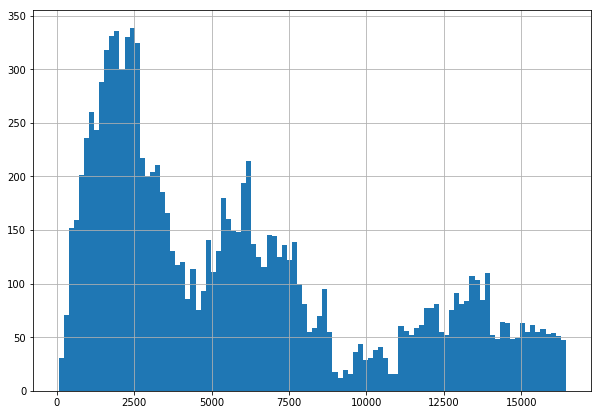

In [60]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

# Data Preprocessing

In [73]:
df_preproc = data

In [74]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 175 entries, Ranking to City_nan
dtypes: float64(6), int64(134), uint8(35)
memory usage: 55.1 MB


In [75]:
# Выделение тестовой части
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [76]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [77]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 174), (40000, 174), (40000, 173), (32000, 173), (8000, 173))

# Model 
Сам ML

In [78]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [79]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [80]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [81]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.209504375


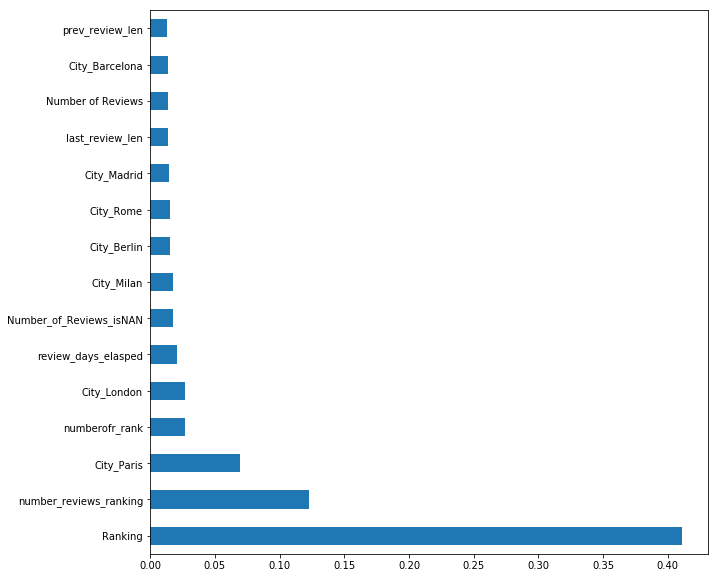

In [82]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [83]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Reviews_isNaN,Afghani,African,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
520,8636.0,2,70.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5472,13080.0,2,2.0,0.0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8450,1128.0,2,2.0,0.0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2128,1378.0,2,7.0,0.0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6992,403.0,2,3.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9386,2307.0,2,958.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7418,5402.0,2,7.0,0.0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1669,5516.0,2,24.0,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6261,4703.0,2,18.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4577,176.0,2,91.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
test_data = test_data.drop(['Rating'], axis=1)

In [85]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [86]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [87]:
predict_submission

array([3.01 , 4.245, 4.495, ..., 3.03 , 4.5  , 4.295])

In [88]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.010
1,id_1,4.245
2,id_2,4.495
3,id_3,4.375
4,id_4,4.420
5,id_5,4.515
6,id_6,2.725
7,id_7,2.950
8,id_8,4.125
9,id_9,4.605
